<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Practice-Session-1-(Sess-#6)" data-toc-modified-id="Practice-Session-1-(Sess-#6)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Practice Session 1 (Sess #6)</a></span><ul class="toc-item"><li><span><a href="#Steps-to-be-followed" data-toc-modified-id="Steps-to-be-followed-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Steps to be followed</a></span></li></ul></li><li><span><a href="#Read-the-dataset" data-toc-modified-id="Read-the-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read the dataset</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Imputation-and-Scaling" data-toc-modified-id="Imputation-and-Scaling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imputation and Scaling</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Evaluation-and-Validation" data-toc-modified-id="Evaluation-and-Validation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation and Validation</a></span></li></ul></div>

# Practice Session 1 (Sess #6)

We're putting in practice what we need to know about feature engineering and model validation.

The goal of this week is to practice on most of the topics, so I will experiment with a new (at least, for me) dataset that can be found [here](http://archive.ics.uci.edu/ml/datasets/Cylinder+Bands). It contains $p=39$ attributes or features, mixed between categorical, integer and real, with a total of $m=512$ samples. The target variable is the one called `band type`, taking the values `band` or `not band`.

## Steps to be followed

1. Read the dataset
2. Data preparation: Check for variable types, NAs, values imputation, column names, scaling, encoding, etc.
3. EDA (Exploratory Data Analysis): Try to extract some insights from the data like features completely uncorrelated or under-represented. Can we merge values from any of the categorical features? Would it be beneficial to discrretiza numerical features? Do we have outliers?
3. Baseline: Simply take the simpler possible model (logistic regression) and set a base score that we'll try to improve along the process. To run logistic regression **you need** to have **numerical features**, so the fastest way of preparing your data to be used in `lr` is to perform _one hot encoding_. Perform this encoding so that you don't destroy the original prepared data. Consider to include onehot encoding as an step which is done right before evaluation over a copy of your prepared data.
4. Feature Engineering: We will try
    - categorical encoding: compare techniques like onehot and target encoding
    - feature selection: compare the results from filtering, wrappers and regularization
    - feature construction: compare GPLearn with _ad hoc_ methods, or Deep Feature Synthesis.
5. Evaluation: the goal here is to fine tune our models, so, to do that we need a new model, like **decission trees**, in this case. We will experiment with:
    - Cross validation and bootstrapping comparison.
    - Fine tune tree parameters: pruning and parameters optimization.

# Read the dataset

Uncomment the following line if you need to install the `dataset` package if you want to go faster, or use Pandas to read it directly.

In [1]:
# !pip install --upgrade git+http://github.com/renero/dataset

Place all the imports at the top of the notebook.

In [2]:
from copy import copy
from dataset import Dataset

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn_pandas import CategoricalImputer

/Users/renero/.virtualenvs/dataset/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Read the `bands.csv` file located in the same dir as this notebook. Remember to download the CSV file.

In [3]:
url = 'bands.csv'
data:Dataset = Dataset(url) # 'data' is now holding the dataset object
df = data.features  # 'df' is now holding the pandas DataFrame

# Make the feature 'band_type' the target variable, and replace the labels
# 'band' and 'noband' in the data for '1' and '0'
data.set_target('band_type')
data.target = data.target.replace('noband', 0)
data.target = data.target.replace('band', 1)

# I'm droping timestamp. I don't want to deal with time series at this point,
# nor considering the timely variations of data.
data.drop_columns('timestamp')

data.describe()

38 Features. 539 Samples
Available types: [dtype('O') dtype('float64')]
  · 15 categorical features
  · 23 numerical features
  · 8 categorical features with NAs
  · 20 numerical features with NAs
  · 11 Complete features
--
Target: band_type (int64)
'band_type'
  · Min.: 0.0000
  · 1stQ: 0.0000
  · Med.: 0.0000
  · Mean: 0.4212
  · 3rdQ: 1.0000
  · Max.: 1.0000


# Data Preparation

You've a lot of NA's so you can explore imputation techniques here. Once that's check outliers, scale numerical variables, all to the same range, and you should be done.

To know what features contain NA values, you can use `Dataset` property `data.incomplete_features` or look up for them in pandas using `is_na().any()` over columns.

In [4]:
# You can also use `data.numerical_features_na` or `data.categorical_features_na`
data.incomplete_features

['grain_screened',
 'proof_on_ctd',
 'blade_mfg',
 'direct_steam',
 'solvent_type',
 'type_on_cylinder',
 'cylinder_size',
 'paper_mill_location',
 'plating_tank',
 'proof_cut',
 'viscosity',
 'caliper',
 'ink_temperature',
 'humifity',
 'roughness',
 'blade_pressure',
 'varnish_pct',
 'press_speed',
 'ink_pct',
 'solvent_pct',
 'ESA_Voltage',
 'ESA_Amperage',
 'wax',
 'hardener',
 'roller_durometer',
 'current_density',
 'anode_space_ratio',
 'chrome_content']

Your first decision has to do with WHAT to do with NA's. Then, scale numerical variables, and finally check if all categorical variables are correctly encoded.

I must count how many NA's do I have per incomplete feature ([info on how to do it on stackoverflow](https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe)).

In [5]:
# Get the number of NAs per feature
num_nas = []
for feature in data.incomplete_features:
    num_nas.append(data.features[feature].isna().sum())
print(f'{len(data.incomplete_features)} features have a median of {math.floor(np.median(num_nas))} NAs')

28 features have a median of 28 NAs


## Imputation and Scaling

There are [several ways of imputing missing values](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation). I'd like to use a multivariate approach, which is much better than univariate methods (imputing by the mean, etc.). To do so, I will use the methods available in `scikit-learn` library ([here](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)).

In [6]:
num_imputer = IterativeImputer(max_iter=10, random_state=0)
num_feats = num_imputer.fit_transform(data.features[data.numerical_features].values)

To perform imputaton on categorical variables, I decided to use a method provided by the library `sklearn_pandas` that implements a `CategoricalImputer`.

In [7]:
cat_imputer = CategoricalImputer()
df = pd.DataFrame()
for col in data.categorical_features_na:
    df[col] = cat_imputer.fit_transform(data.features[col].values)
ds = Dataset.from_dataframe(df)

Finally, the result of imputing both: numerical and categorical, is now merged together in a single Dataset (or you can also use a dataframe, if you prefer).

In [8]:
ds.add_columns(data.target)
ds.to_categorical('band_type')

# add the resulting imputed numerical features to the categorical imputed
ds.add_columns(pd.DataFrame(num_feats, columns=data.numerical_features));

Scale all the numeric values, at this point.

In [9]:
del(data)
data = ds.scale();
data.set_target('band_type')

Now, my dataset is ready to be analyzed. Lots of categorical and numerical variables.

# EDA

I will run a very short EDA as I don't want to condition your work. I will simply rely on basic counts and histograms against the target variable, to see if there's something wrong. I will use a method called `summary` to know better what's the status of each feature:

In [10]:
data.summary()

Features Summary (all):
'grain_screened'     : object     2 categs. 'YES'(329, 0.6104) 'NO'(210, 0.3896) 
'proof_on_ctd'       : object     2 categs. 'YES'(517, 0.9592) 'NO'(22, 0.0408) 
'blade_mfg'          : object     2 categs. 'BENTON'(538, 0.9981) 'UDDEHOLM'(1, 0.0019) 
'direct_steam'       : object     3 categs. 'NO'(524, 0.9722) 'YES'(13, 0.0241) 'no'(2, 0.0037) 
'solvent_type'       : object     3 categs. 'LINE'(522, 0.9685) 'XYLOL'(15, 0.0278) 'NAPTHA'(2, 0.0037) 
'type_on_cylinder'   : object     4 categs. 'YES'(375, 0.6957) 'NO'(134, 0.2486) 'no'(28, 0.0519) 'yes'(2, 0.0037) 
'cylinder_size'      : object     6 categs. 'TABLOID'(284, 0.5269) 'CATALOG'(164, 0.3043) 'SPIEGEL'(54, 0.1002) 'catalog'(17, 0.0315) ...
'paper_mill_location': object     6 categs. 'NorthUS'(344, 0.6382) 'CANADIAN'(158, 0.2931) 'CANAdiAN'(15, 0.0278) 'SCANDANAVIAN'(13, 0.0241) ...
'job_number'         : float64    Min.(-1.6) 1stQ(-0.3) Med.(-0.1) Mean(-3.0) 3rdQ(0.02) Max.(5.83)
'press'              : 

I also want to know how may samples belong to the class '1' and how many to class '0', simply to check if the data set is balanced (you can see that YES, it is).

In [11]:
data.target.value_counts()

0    312
1    227
Name: band_type, dtype: int64

Starting by knowing if there're underrepresented features: this is, values that are only present in a very small portion of the samples. I will use a method called, precisely, `under_represented_features()` from the Dataset library that will return those features presenting values under a given threshold.

In [12]:
under_repr = data.under_represented_features(threshold=0.9)
print(under_repr)

['proof_on_ctd', 'blade_mfg', 'direct_steam', 'solvent_type']


Let's see what's the situation in the categories of those clases. I will simply count the number of unique values present at each of those columns (above):

In [13]:
for col in under_repr:
    print(col)
    res = data.features.proof_on_ctd.value_counts()
    print(f'{res}\n----')

proof_on_ctd
YES    517
NO      22
Name: proof_on_ctd, dtype: int64
----
blade_mfg
YES    517
NO      22
Name: proof_on_ctd, dtype: int64
----
direct_steam
YES    517
NO      22
Name: proof_on_ctd, dtype: int64
----
solvent_type
YES    517
NO      22
Name: proof_on_ctd, dtype: int64
----


From that result, we will remove those features, as they are not very informative (a priori). You can also combine them into a single feature by merging the four of them.

In [14]:
data.drop_columns(under_repr)

Taking a log at `paper_mill_location` you can also find how the values contain discrepancies in the upper and lower case used for encoding its values. The solution is to merge categories.

In [15]:
data.features.paper_mill_location.value_counts()

NorthUS         344
CANADIAN        158
mideuropean      15
SCANDANAVIAN     13
SouthUS           8
CANAdiAN          1
Name: paper_mill_location, dtype: int64

We will (blindly) be a bit more agressive and merge also Scandinavian with mideuropean to form a new category called "European", and SouthUS with NorthUS to form a new one called "NSAmerica". We will also cleanup the case mess with the variable `type_on_cylinder` and `cylinder_size`.

In [16]:
data.merge_categories('paper_mill_location', old_values=['CANADIAN', 'CANAdiAN'], new_value='Canadian')
data.merge_categories('paper_mill_location', old_values=['mideuropean', 'SCANDANAVIAN'], new_value='European')
data.merge_categories('paper_mill_location', old_values=['NorthUS', 'SouthUS'], new_value='NSAmerica')
data.merge_categories('type_on_cylinder', old_values=['YES', 'yes'], new_value='YES')
data.merge_categories('type_on_cylinder', old_values=['NO', 'no'], new_value='NO')
data.merge_categories('cylinder_size', old_values=['CATALOG', 'catalog'], new_value='CATALOG')
data.merge_categories('cylinder_size', old_values=['TABLOID', 'tabloid'], new_value='CATALOG')
data.merge_categories('cylinder_size', old_values=['SPIEGEL', 'spiegel'], new_value='SPIEGEL')
print(data.features.paper_mill_location.value_counts())

NSAmerica    352
Canadian     159
European      28
Name: paper_mill_location, dtype: int64


Let's take a look at the histograms of the numerical values.

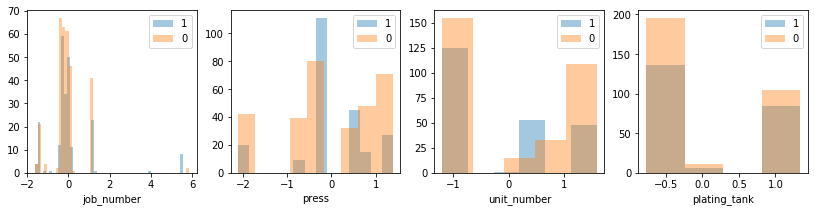

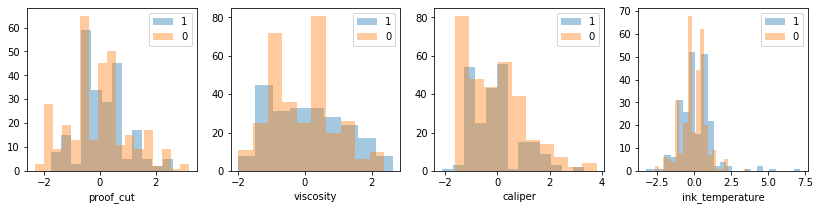

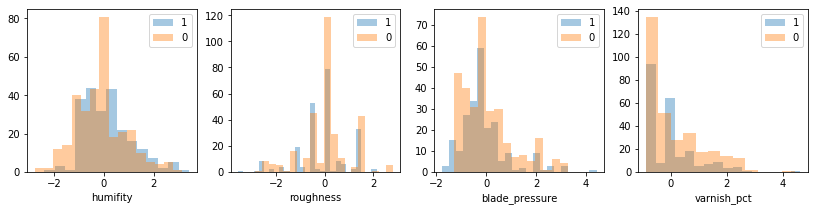

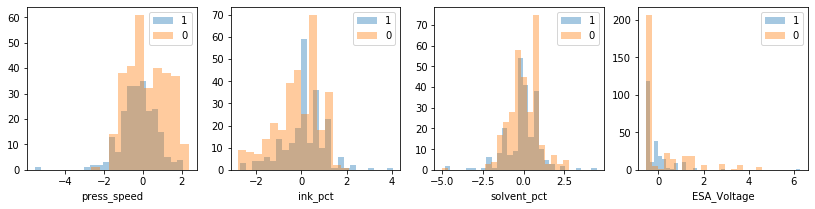

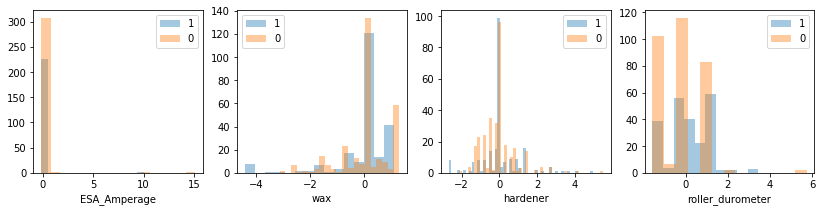

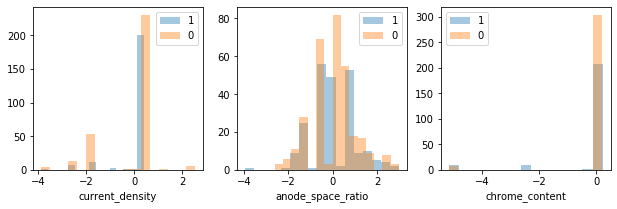

In [17]:
data.plot_histogram()

We could do many things (I hope you do!) but for the moment I'm simply removing (bad decision without checking what's the effect of this change) `ESA_Amperage` and `chrome_content` since they seem to be not very informative on the target variable.

In [18]:
data.drop_columns(['ESA_Amperage','chrome_content'])
data.summary()

Features Summary (all):
'grain_screened'     : object     2 categs. 'YES'(329, 0.6104) 'NO'(210, 0.3896) 
'type_on_cylinder'   : object     2 categs. 'YES'(403, 0.7477) 'NO'(136, 0.2523) 
'cylinder_size'      : object     2 categs. 'CATALOG'(479, 0.8887) 'SPIEGEL'(60, 0.1113) 
'paper_mill_location': object     3 categs. 'NSAmerica'(352, 0.6531) 'Canadian'(159, 0.2950) 'European'(28, 0.0519) 
'job_number'         : float64    Min.(-1.6) 1stQ(-0.3) Med.(-0.1) Mean(-3.0) 3rdQ(0.02) Max.(5.83)
'press'              : float64    Min.(-2.1) 1stQ(-0.3) Med.(-0.2) Mean(-6.5) 3rdQ(0.84) Max.(1.38)
'unit_number'        : float64    Min.(-1.1) 1stQ(-0.8) Med.(-0.8) Mean(3.29) 3rdQ(1.26) Max.(1.57)
'plating_tank'       : float64    Min.(-0.7) 1stQ(-0.7) Med.(-0.7) Mean(-1.4) 3rdQ(1.34) Max.(1.34)
'proof_cut'          : float64    Min.(-2.3) 1stQ(-0.5) Med.(-0.0) Mean(-6.2) 3rdQ(0.56) Max.(3.18)
'viscosity'          : float64    Min.(-1.9) 1stQ(-0.9) Med.(-0.1) Mean(-4.2) 3rdQ(0.62) Max.(2.62)
'cali

# Baseline

I will build a method to evaluate a basic logistic regression over a split of the data set using cross validation. We will discuss about this one tomorrow...

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef

def evaluate_LogReg(X_train, y_train, X_test, y_test, 
                    return_score='F1',
                    printout=False):
    """
    Fits a logistic regression with the training set, and evaluates it with 
    the test set, using Accuracy, F1, Recall or MCC metrics

    """
    lr = LogisticRegression().fit(X_train, y_train)
    y_hat = lr.predict(X_test)

    accuracy = accuracy_score(y_test, y_hat)
    F1 = f1_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    MCC = matthews_corrcoef(y_test, y_hat)
    
    if printout is True:
        print('Accuracy:', accuracy)
        print('F1:', F1)
        print('Recall:', recall)
        print('MCC:', MCC)
    
    return eval(return_score)

# Feature Engineering

# Evaluation and Validation